In [72]:
import os
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
from osgeo import ogr
import matplotlib.pyplot as plt
import tarfile
import rasterio
import geopandas
import numpy as np
import rasterio
from rasterio.plot import show
import math

# Defining functions to calculate Net Primary Productivity (NPP)

In [4]:
#Unzip the files
def unzip_file(tar_path, ext_path):
    """This function unzips the tar files.
    
    tar_path: the source of the tar file
    ext_path: the destination of the unzipped files
    """
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(path=ext_path)  

In [8]:
def list_full_paths(directory):
    """This function ties the file path with the file name.
    
    directory: the directory from where the path and files should be printed
    """
    return [os.path.join(directory, file) for file in os.listdir(directory) if file[-4:]=='.tif']

In [24]:
def stack_raster(input_rasters, out_stack):
    """The function stacks multiple bands from raster image into a multi-band raster.
    Made a stack of four bands used in this analysis. In the stacked raster, band 4 corresponds to band 1, 
    band 5 corresponds to band 2, band 6 corresponds to band 3, band7 corresponds to band 4.
    
    input rasters: is the list of .tif files with their path to be stacked
    out_stack: file path and name of the output stack 
    """
    
    #Setting the size and projection of the raster
    raster = gdal.Open(input_rasters[0])
    rows, cols = raster.RasterYSize, raster.RasterXSize
    projc = raster.GetProjection()
    
    #Band List
    band_list = []
    
    #Looping through the input files to read data
    for layer in input_rasters:
        band = gdal.Open(layer)
        data = band.ReadAsArray()
        band_list.append(data)
        
    #Stacking the bands
    stacked_data = np.dstack(band_list)
    
    # Create the output raster file
    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(out_stack, cols, rows, 4, gdal.GDT_Float32)
    
    # Loop through the stacked data and write it to the output raster bands
    for i in range(4):
        out_band = out_raster.GetRasterBand(i+1)
        out_band.WriteArray(stacked_data[:, :, i])
        
    # Set the projection of the output raster file
    out_raster.SetProjection(projc)

    # Save and close the output raster file
    out_raster.FlushCache()
    out_raster = None


In [46]:
#calculating NDVI for the two sites for 2017 & 2022
def ndvi_raster(input_raster, output_ndvi):
    """This function calculates NDVI from the input raster using the red(band 1) and near infra-red band(band 2)
    
    input rasters: is the raster using which NDVI is to be calculated
    out_stack: file path and name of the output NDVI
    """
    #Open the raster for which NDVI is to be calculated
    n_raster = gdal.Open(input_raster)
    
    #Setting the red and near-infrared bands
    b4 = n_raster.GetRasterBand(1)
    b5 = n_raster.GetRasterBand(2)
    
    #Reading band data as an array
    b4_data = b4.ReadAsArray()
    b5_data = b5.ReadAsArray()
    
    #Calculating NDVI
    ndvi_data = (b5_data - b4_data)/(b5_data + b4_data)
    
      
    # Create the output raster file
    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_ndvi, n_raster.RasterXSize, n_raster.RasterYSize, 1, gdal.GDT_Float32)
    
    # Write NDVI data to the output raster band
    out_band = out_raster.GetRasterBand(1)
    out_band.WriteArray(ndvi_data)

    # Set NoData value for output band
    out_band.SetNoDataValue(-9999)

    # Set the projection and geotransform
    out_raster.SetProjection(n_raster.GetProjection())
    out_raster.SetGeoTransform(n_raster.GetGeoTransform())
    
    # Close the datasets
    n_raster = None
    out_raster = None    

In [70]:
#Function that calculates the final NPP rpoduct using NDVI raster
def final_output(input_raster, ndvi_raster, final_raster):
    """This function calculates the Net Primary Productivity and saves it as a raster.
    
    input raster: stacked raster used to calculate Water Stress coefficient
    ndvi_raster: raster that has NDVI for the given region and time period
    final_raster: output raster that has NPP values for the given region and time period
    """
    #Open raster to calculate SIMI, NSIMI, and finally WSC
    w_raster = gdal.Open(input_raster)
    
    ##Setting the SWRI Bands
    b6 = w_raster.GetRasterBand(3)
    b7 = w_raster.GetRasterBand(4)
    
    ##Reading band data as an array
    b6_data = b6.ReadAsArray()
    b7_data = b7.ReadAsArray()
    
    ##Calculating Shortwave infrared soil moisture index (SIMI)
    SIMI = ((b6_data**2 + b7_data**2)**0.5)*0.7071
    
    SIMI_min = SIMI.min()
    SIMI_max = SIMI.max()
    
    ##Calculating normalized SIMI
    NSIMI = (SIMI - SIMI_min)/(SIMI_max - SIMI_min)
    
    ##Calculating WSC
    WSC = 0.5 + 0.5*(1-NSIMI)
    
    #Calculating FPAR using NDVI, FPARMIN, FPARMAX
    
    ##Loading the NDVI raster
    n_raster = gdal.Open(ndvi_raster)
    
    #Loading the NDVI raster band and sotring the data in an array
    ndvi_band = n_raster.GetRasterBand(1)
    ndvi_data = ndvi_band.ReadAsArray()
    
    NDVI_min = ndvi_data.min()
    NDVI_max = ndvi_data.max()
    
    #Declaring FPARMIN and FPARMAX constants as defined in Wang et al. 2017
    FPAR_max = 0.95
    FPAR_min = 0.001
    
    #Calculatin Fraction of absorbed photosynthetically active radiation (FPAR) 
    
    FPAR = (((ndvi_data - NDVI_min)*(FPAR_max - FPAR_min))/(NDVI_max - NDVI_min))  + FPAR_min
    
    #Calculating Light Utilization Efficiency
    T = 27 # monthly average temperature (in degree celcius) for november for region close to both study sites
    T_opt = 26.34 #Yearly average temperature (in degree celcius) for region close to both study sites
    
    T1 = 0.8 + 0.02*T_opt - 0.0005*(T_opt)**2
    
    T21D = 1 + math.exp(0.2 * (T_opt - 10 - T))
    T21N = 1.1814
    
    T21 = T21N/T21D
    
    T22D = 1 + math.exp(0.3 * (-T_opt - 10 + T))
    
    T22 = 1/T22D
    
    T2 = T21*T22
    
    #Calculating NPP
    SOL = 578.1 #total solar radiation (MJ m^-2 per month) 
    e_max = 1.044 #maximum radiation conversion efficiency (gCMJ^-1)
    
    NPP = 0.5*SOL*e_max*FPAR*T1*T2*WSC
    
    # Create the output raster file
    driver = gdal.GetDriverByName("GTiff")
    output = driver.Create(final_raster, n_raster.RasterXSize, n_raster.RasterYSize, 1, gdal.GDT_Float32)
    
    # Write NDVI data to the output raster band
    output_ds = output.GetRasterBand(1)
    output_ds.WriteArray(NPP)

    # Set NoData value for output band
    output_ds.SetNoDataValue(-9999)

    # Set the projection and geotransform
    output.SetProjection(n_raster.GetProjection())
    output.SetGeoTransform(n_raster.GetGeoTransform())
    
    # Close the datasets
    n_raster = None
    output_ds = None   
    w_raster = None


In [165]:
def plot_raster(input_raster, title):
    """
    Opens a raster using rasterio and plots it using matplotlib.

    file_path: File path for the raster to be plotted.
    title: Title to be used for the plot
    """
    # Open the raster using rasterio
    raster = rasterio.open(input_raster)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

    # Plot the raster using rasterio.plot.show
    image_hidden = ax.imshow(raster.read(1, masked=True), cmap='viridis')
    cbar = fig.colorbar(image_hidden, ax=ax)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Net Primary Productivity (gC per square meter per month)', rotation=90)
    show(raster, ax=ax, cmap='viridis', title =title)
    
    raster.close()

    # Hide the axes
    ax.set_axis_off()

    return fig, ax

In [148]:
def raster_stats(input_raster, year, site):
    # Open the raster using rasterio
    raster = gdal.Open(input_raster)
    
    #Loading the NDVI raster band and storing the data in an array
    npp_band = raster.GetRasterBand(1)
    npp_data = npp_band.ReadAsArray()

    #Calculate min, max, and mean values of NPP for the raster
    mean_value = npp_data.mean()
    max_value = npp_data.max()
    min_value = npp_data.min()

    # Print the results
    print(f"Mean NPP value for {site}, {year}: {mean_value}")
    print(f"Maximum NPP value for {site}, {year}: {max_value}")
    print(f"Minimum NPP value for {site}, {year}: {min_value}")
    
    # Close the datasets
    raster = None

# Computing NPP

In [5]:
#Unzipping the LANDSAT 8 Raw data
unzip_file('E:/bluesky_analytics/data/2017_KA/kali/LC08_L2SP_146049_20171116_20200902_02_T1.tar', 'E:/bluesky_analytics/data/2017_KA/kali/2017_kali_ext/146_49')
unzip_file('E:/bluesky_analytics/data/2017_KA/kali/LC08_L2SP_146050_20171116_20200902_02_T1.tar', 'E:/bluesky_analytics/data/2017_KA/kali/2017_kali_ext/146_50')
unzip_file('E:/bluesky_analytics/data/2017_MH/radhanagri/LC08_L2SP_147049_20171123_20200902_02_T1.tar', 'E:/bluesky_analytics/data/2017_MH/radhanagri/2017_radh_ext')
unzip_file('E:/bluesky_analytics/data/2022_KA/kali/LC08_L2SP_146049_20221130_20221206_02_T1.tar', 'E:/bluesky_analytics/data/2022_KA/kali/2022_kali_ext/146_49')
unzip_file('E:/bluesky_analytics/data/2022_KA/kali/LC08_L2SP_146050_20221130_20221206_02_T1.tar', 'E:/bluesky_analytics/data/2022_KA/kali/2022_kali_ext/146_50')
unzip_file('E:/bluesky_analytics/data/2022_MH/radhanagri/LC09_L2SP_147049_20221028_20221030_02_T1.tar', 'E:/bluesky_analytics/data/2022_MH/radhanagri/2022_radh_ext')

In [26]:
#Creating a list with tif files for all bands for the two site sites and time periods
KA_2017 = list_full_paths("E:/bluesky_analytics/data/clipped/crop_2017_KA/")
KA_2022 = list_full_paths("E:/bluesky_analytics/data/clipped/crop_2022_KA/")
MH_2017 = list_full_paths("E:/bluesky_analytics/data/clipped/crop_2017_MH/")
MH_2022 = list_full_paths("E:/bluesky_analytics/data/clipped/crop_2022_MH/")

#Creating a list of lists
input_raster_list = [KA_2017, KA_2022, MH_2017, MH_2022]

#defining the path and name of output stack files
out_stacks = ["E:/bluesky_analytics/data/stack/stack_2017_KA.tif", "E:/bluesky_analytics/data/stack/stack_2022_KA.tif", 
              "E:/bluesky_analytics/data/stack/stack_2017_MH.tif", "E:/bluesky_analytics/data/stack/stack_2022_MH.tif"]

#Running the stack_raster function to get four raster stacks
for i, input_rasters in enumerate(input_raster_list):
    out_stack = out_stacks[i]
    stack_raster(input_rasters, out_stack)

In [40]:
#A list with all the rasters for whom NDVI has to be calculated
stack_list = list_full_paths("E:/bluesky_analytics/data/stack/set_null/")

#Defining the path and name of output NDVI files
out_ndvis = ["E:/bluesky_analytics/data/output/NDVI/ndvi_2017_KA.tif", "E:/bluesky_analytics/data/output/NDVI/ndvi_2017_MH.tif", 
            "E:/bluesky_analytics/data/output/NDVI/ndvi_2022_KA.tif", "E:/bluesky_analytics/data/output/NDVI/ndvi_2022_MH.tif"]

#Running the ndvi_raster function to get four ndvi rasters
for i, input_raster in enumerate(stack_list):
    out_ndvi = out_ndvis[i]
    ndvi_raster(input_raster, out_ndvi)

TypeError: list indices must be integers or slices, not str

In [109]:
#A list with all the rasters for whom NDVI has to be calculated
ndvi_stack_list = list_full_paths("E:/bluesky_analytics/data/output/NDVI/")

#A list with all the rasters for whom WSC has to be calculated
raster_stack_list = list_full_paths("E:/bluesky_analytics/data/stack/set_null/")

#Defining the path and name of output NPP files
out_npp2 = ["E:/bluesky_analytics/data/output/NPP_1/npp_2017_KA.tif", "E:/bluesky_analytics/data/output/NPP_1/npp_2017_MH.tif", 
            "E:/bluesky_analytics/data/output/NPP_1/npp_2022_KA.tif", "E:/bluesky_analytics/data/output/NPP_1/npp_2022_MH.tif"]

#Running the final_output function to get four NPP rasters
for i, input_raster in enumerate(raster_stack_list):
    input_ndvi = ndvi_stack_list[i]
    out_npp = out_npp2[i]
    final_output(input_raster, input_ndvi, out_npp)

C:\Users\akshatak\AppData\Local\Temp\ipykernel_3232\1755127657.py:21: RuntimeWarning: overflow encountered in square
  SIMI = ((b6_data**2 + b7_data**2)**0.5)*0.7071
C:\Users\akshatak\AppData\Local\Temp\ipykernel_3232\1755127657.py:27: RuntimeWarning: invalid value encountered in divide
  NSIMI = (SIMI - SIMI_min)/(SIMI_max - SIMI_min)


# Visualizing the NPP plots

(<Figure size 2000x2000 with 2 Axes>,
 <Axes: title={'center': 'Net Primary Productivity, Kali WLS, 2017'}>)

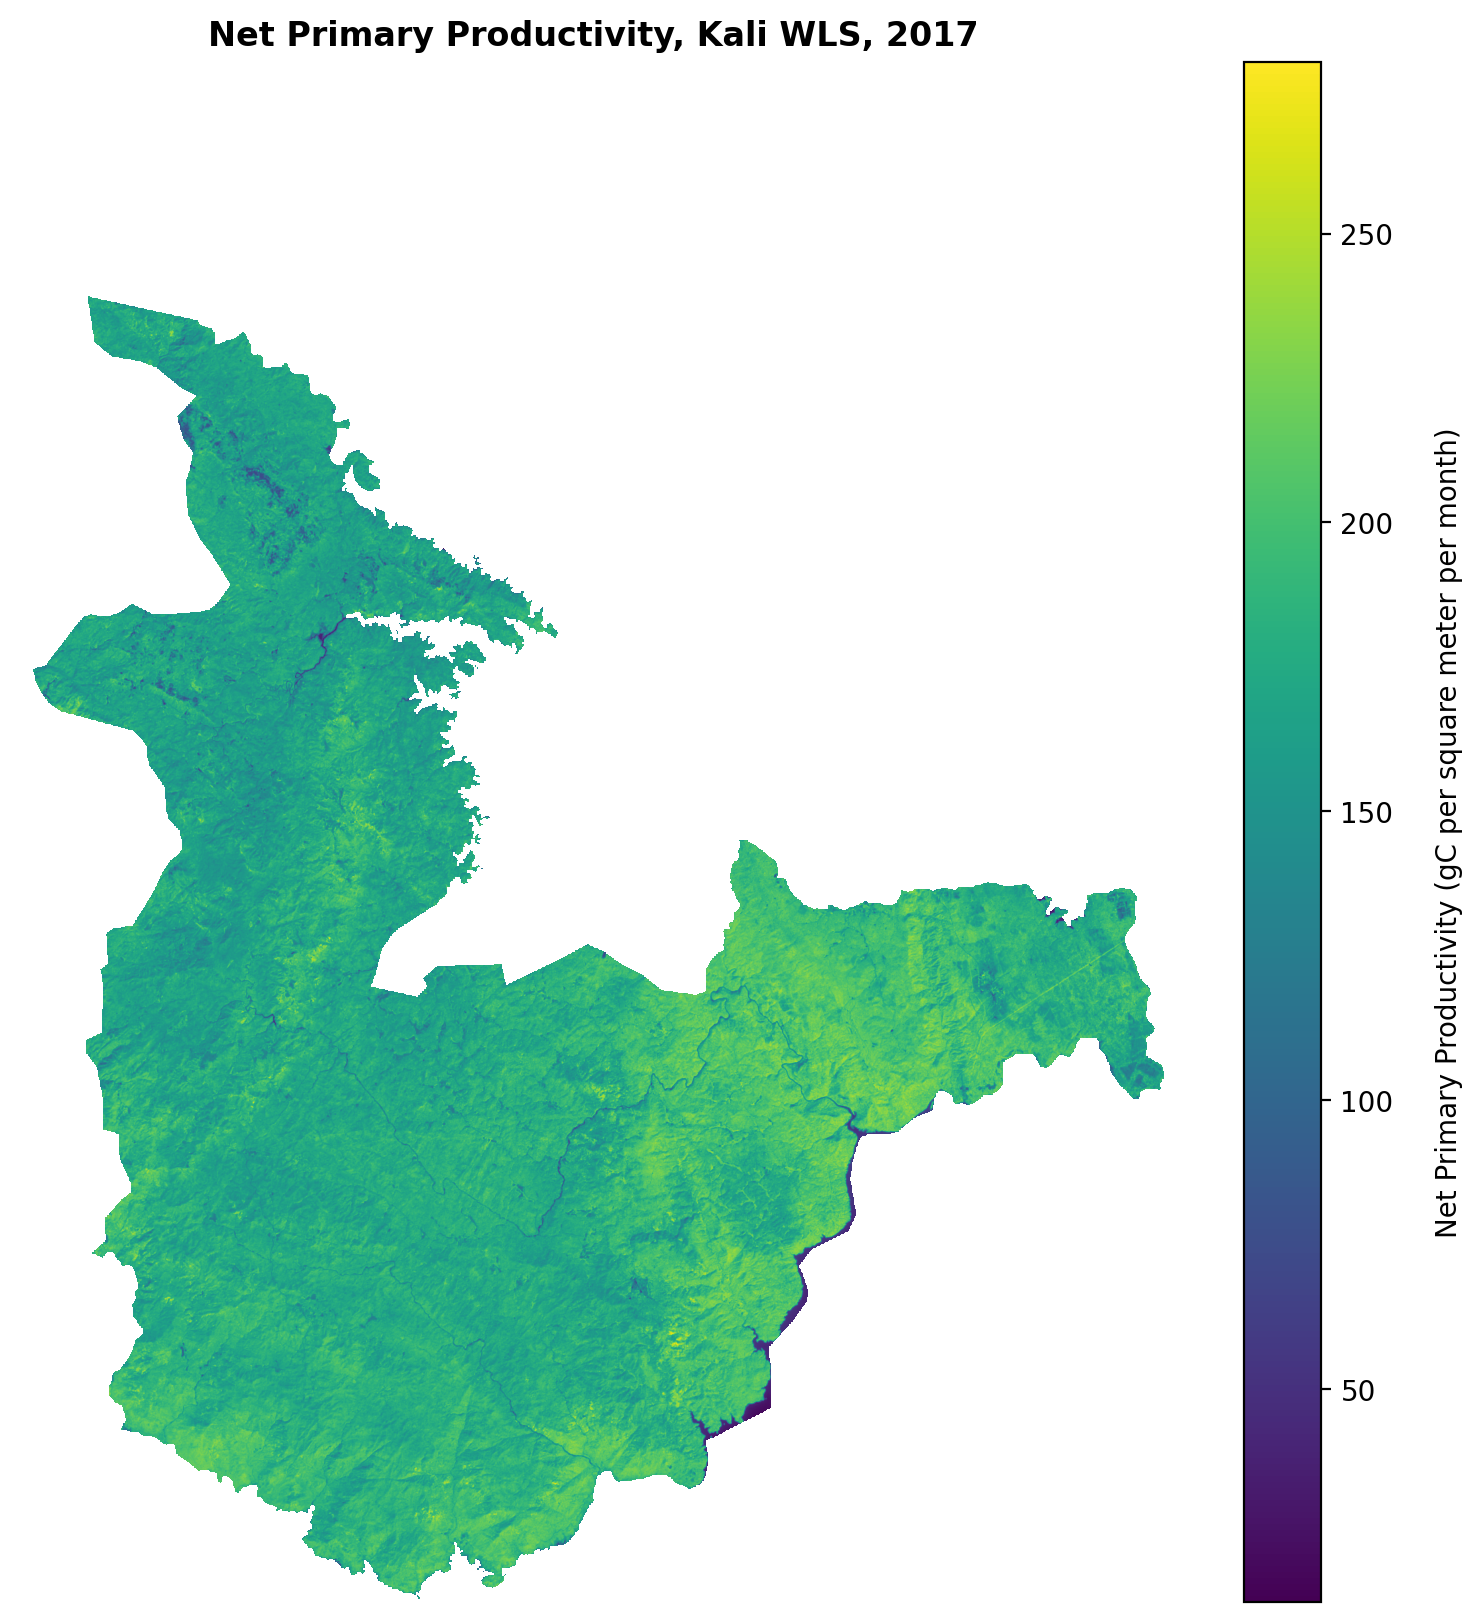

In [131]:
plot_raster("E:/bluesky_analytics/data/output/NPP_1/npp_2017_KA.tif", 'Net Primary Productivity, Kali WLS, 2017')

(<Figure size 2000x2000 with 2 Axes>,
 <Axes: title={'center': 'Net Primary Productivity, Kali WLS, 2022'}>)

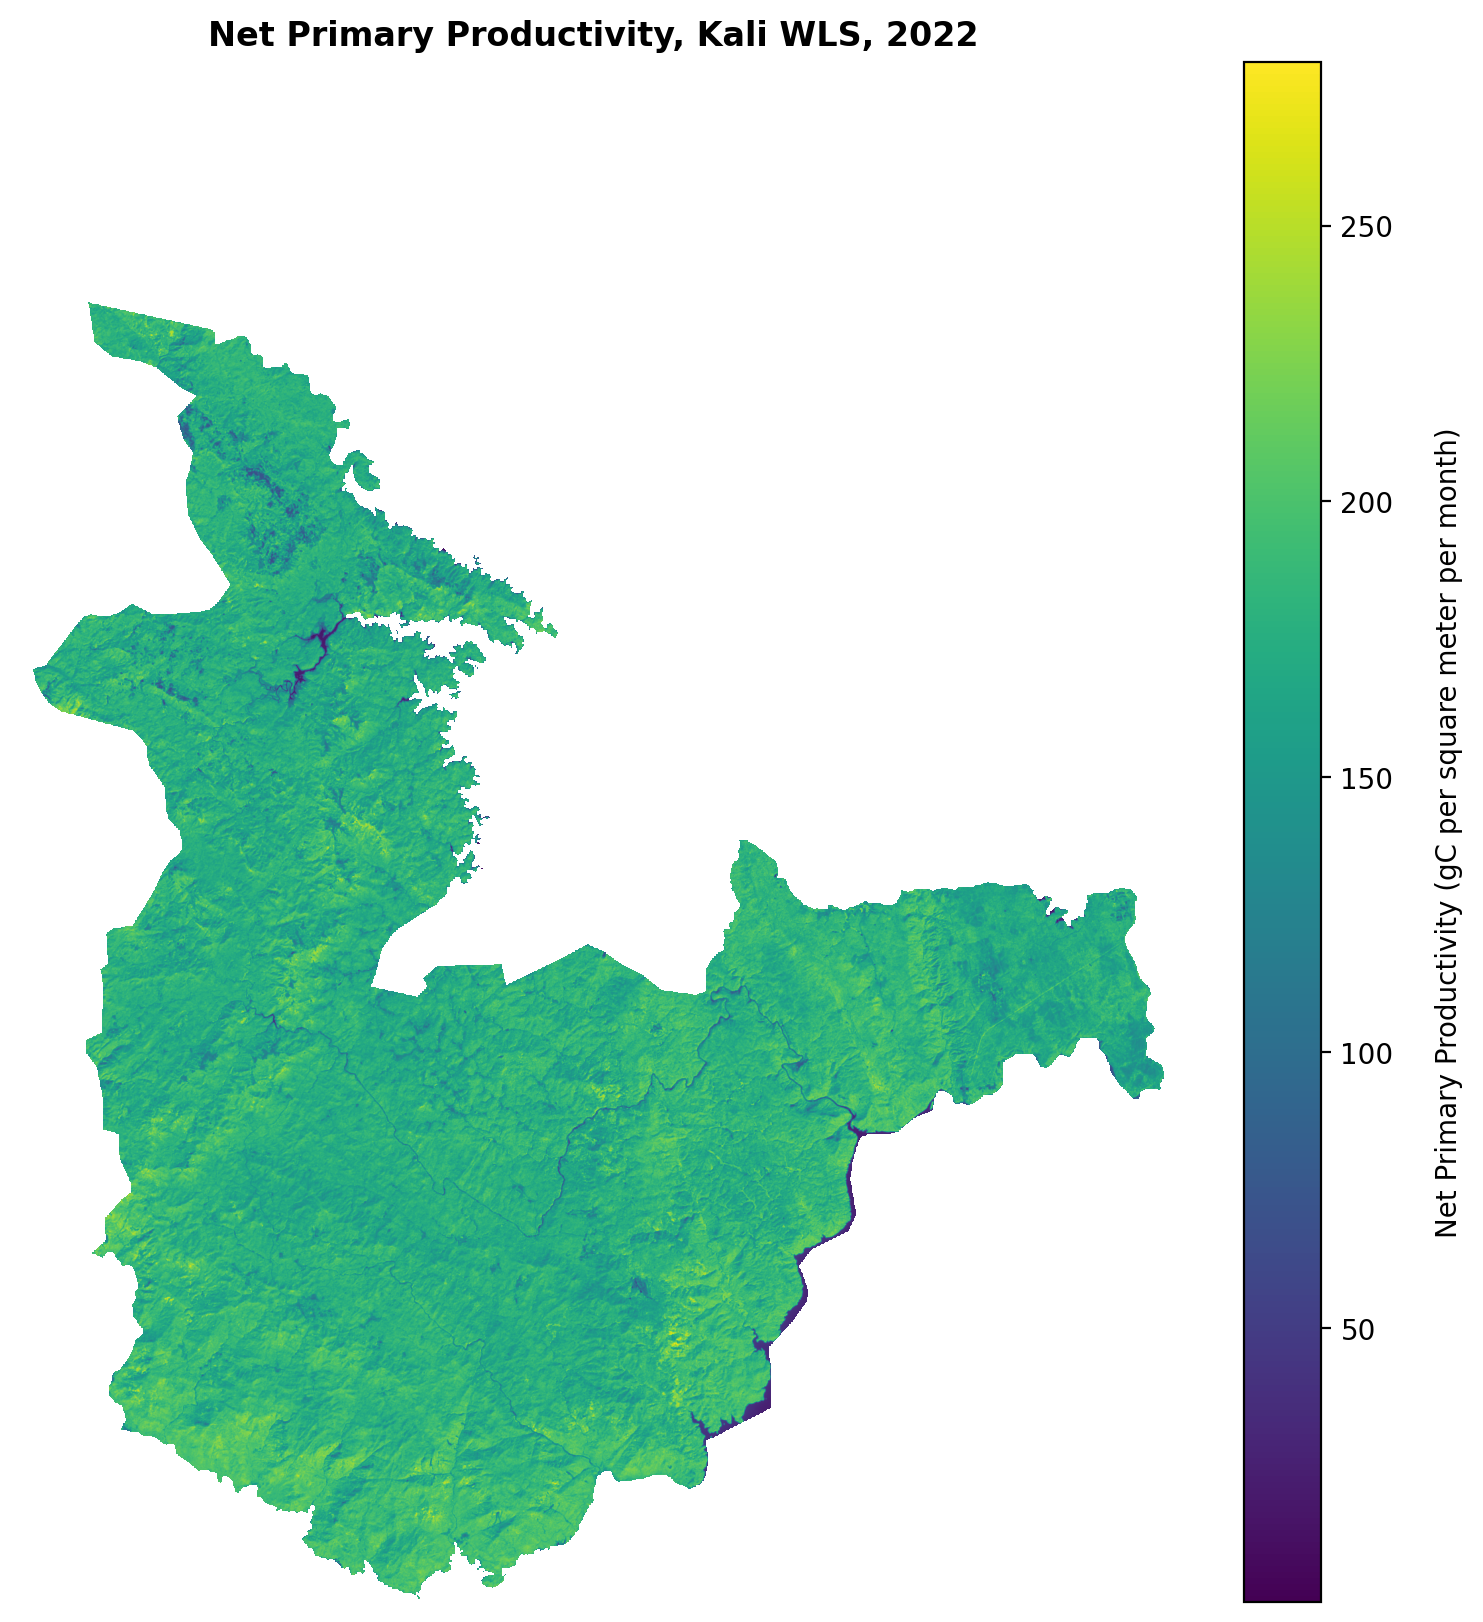

In [132]:
plot_raster("E:/bluesky_analytics/data/output/NPP_1/npp_2022_KA.tif", 'Net Primary Productivity, Kali WLS, 2022')

(<Figure size 2000x2000 with 2 Axes>,
 <Axes: title={'center': 'Net Primary Productivity, Radhanagri WLS, 2017'}>)

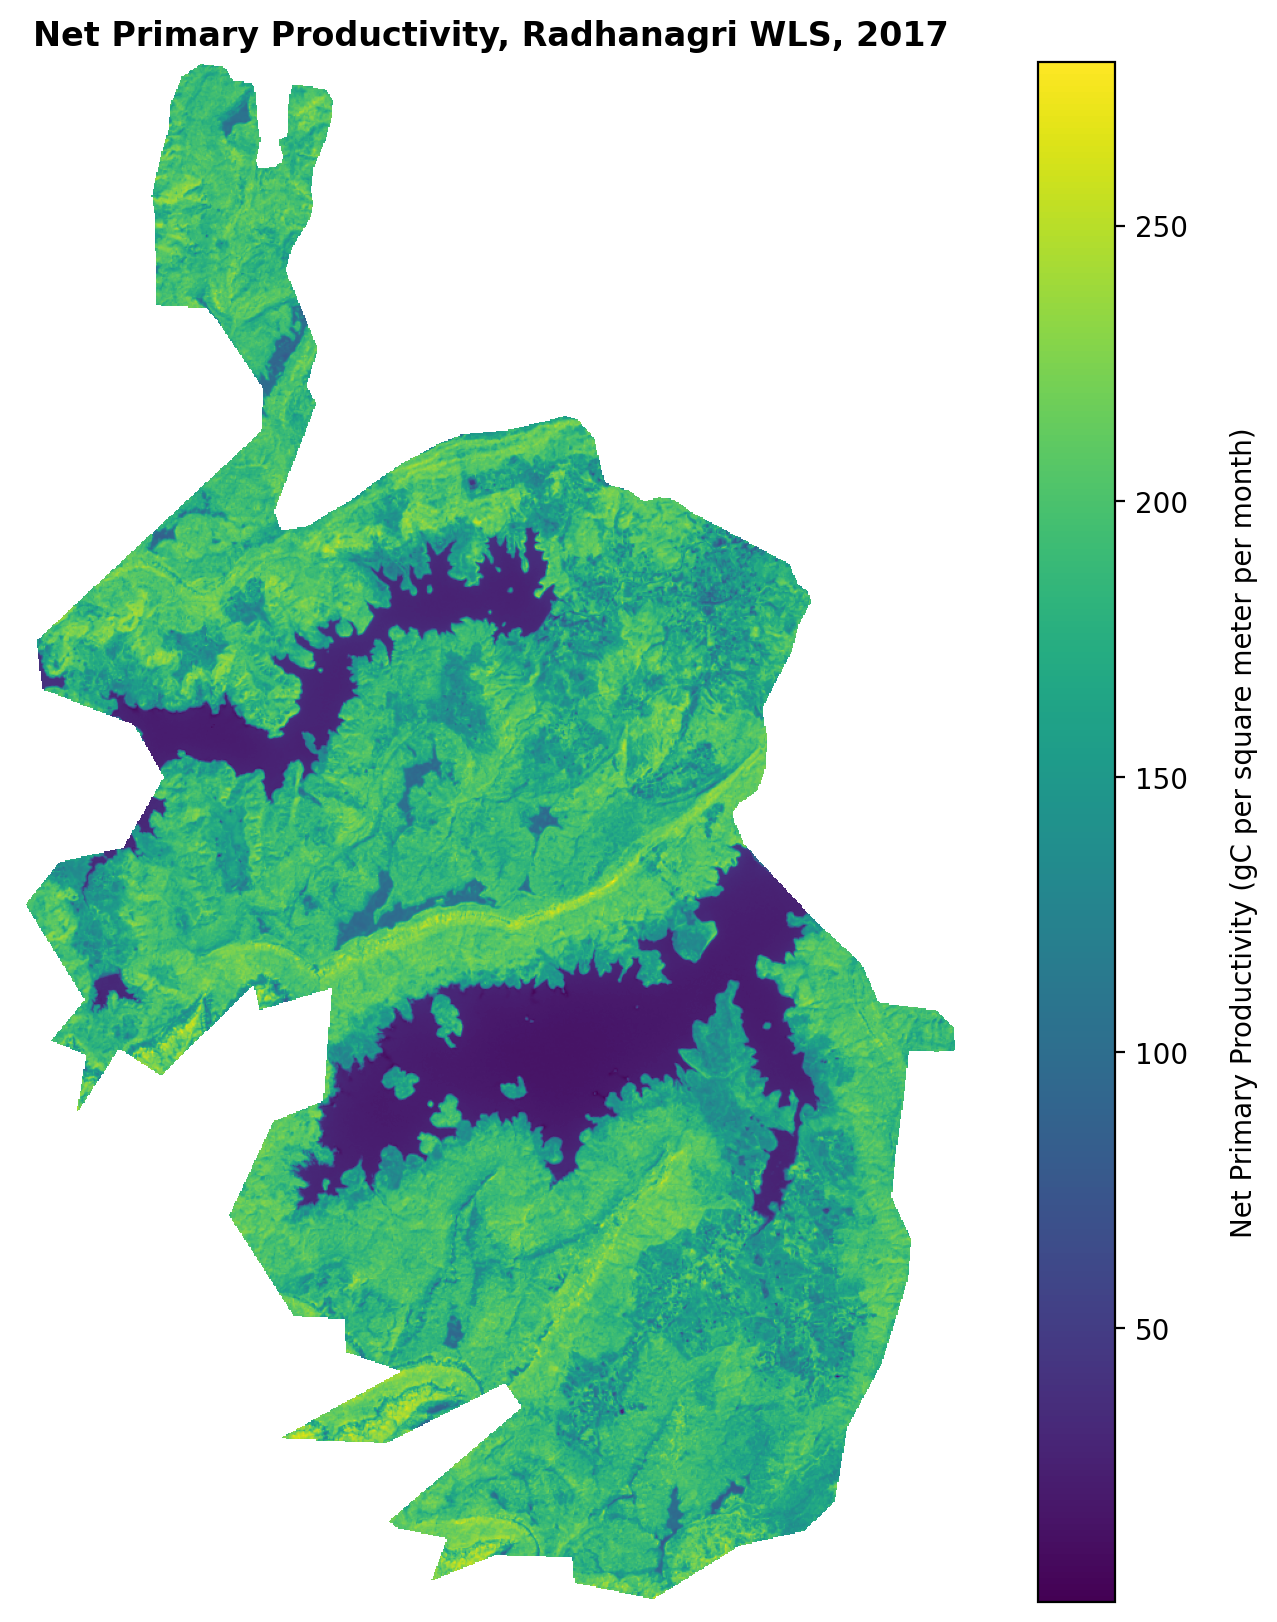

In [133]:
plot_raster("E:/bluesky_analytics/data/output/NPP_1/npp_2017_MH.tif", 'Net Primary Productivity, Radhanagri WLS, 2017')

(<Figure size 2000x2000 with 2 Axes>,
 <Axes: title={'center': 'Net Primary Productivity, Radhanagri WLS, 2022'}>)

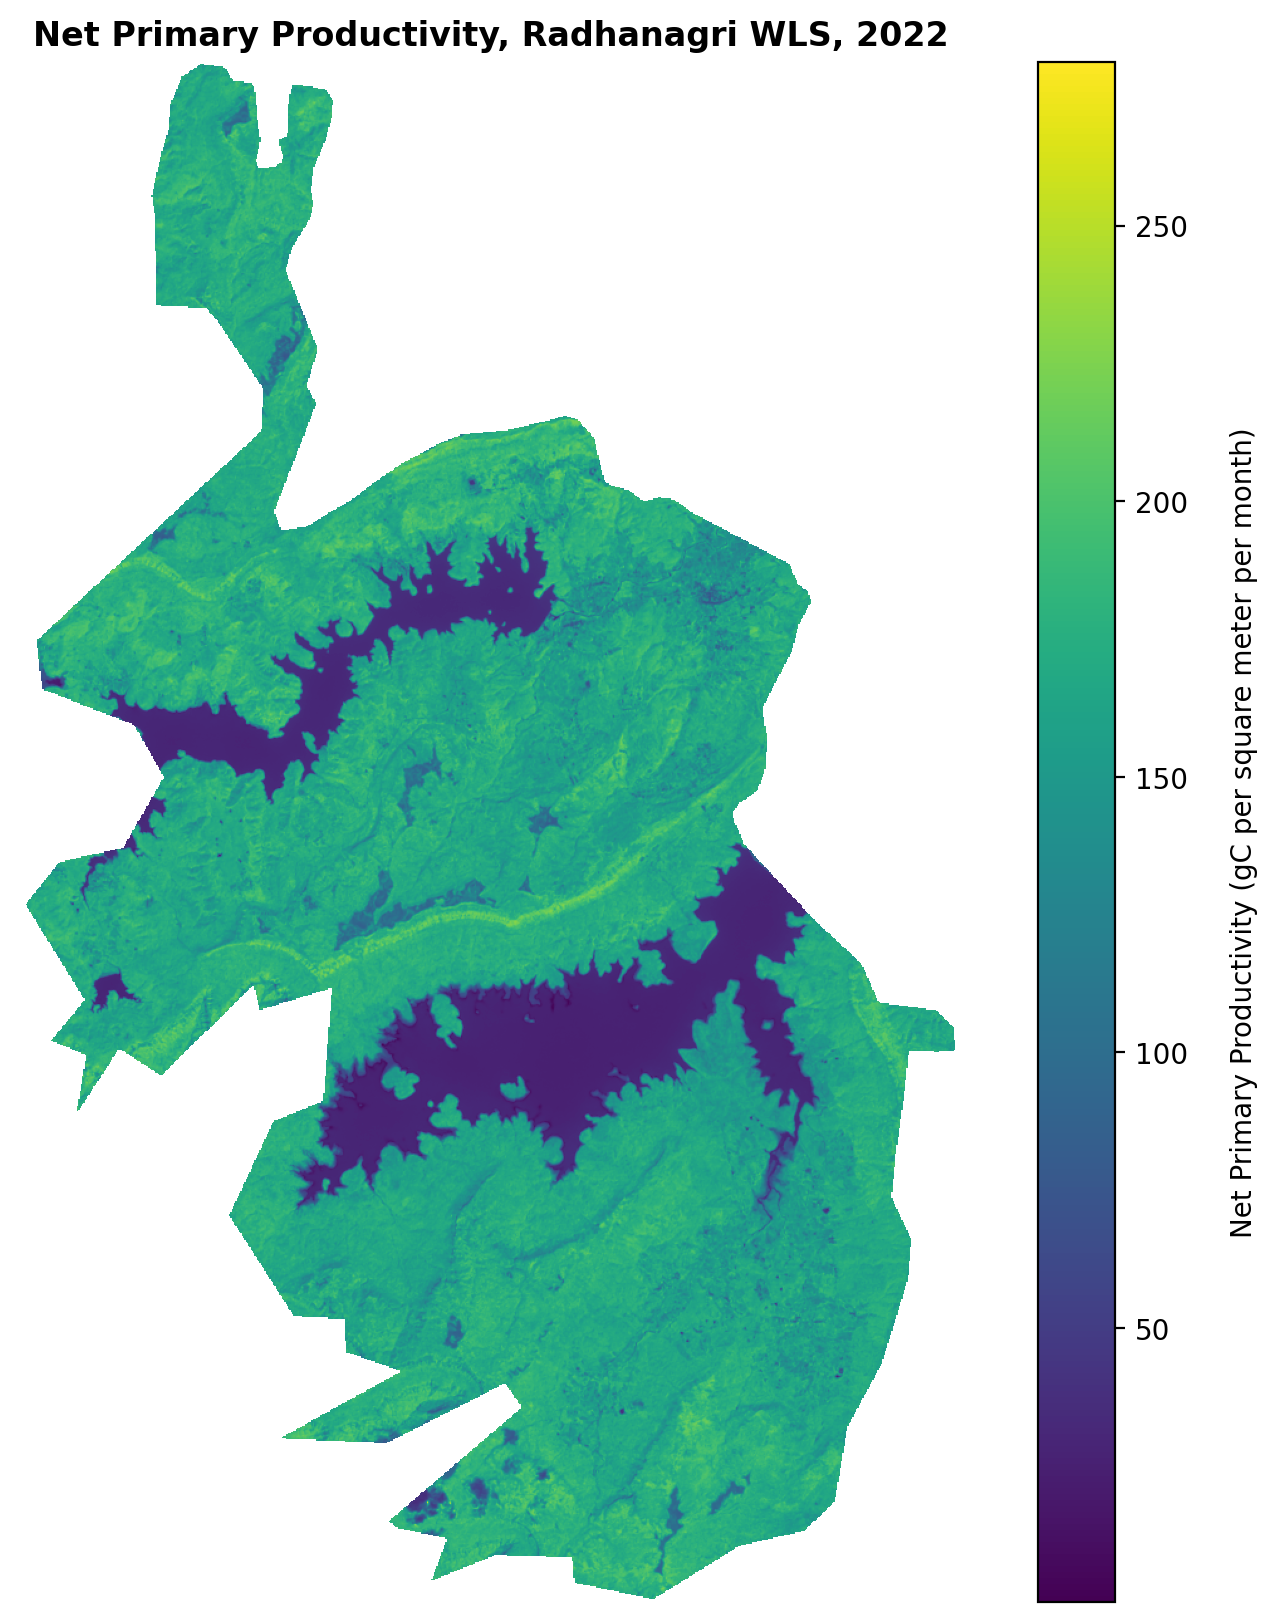

In [166]:
plot_raster("E:/bluesky_analytics/data/output/NPP_1/npp_2022_MH.tif", 'Net Primary Productivity, Radhanagri WLS, 2022')